핸드폰 사용에 대한 일반적 패턴과 개인적 패턴 구분하기

In [376]:
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [377]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
#mpl.font_manager._rebuild()

# https://pinkwink.kr/1255 / https://teddylee777.github.io/colab/colab-korean 한글 문제 대응 참고

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 58 not upgraded.


개인적 패턴을 활용하여 personalized channel recommendation 모델 만들기 

## **🔸 DATA OVERVIEW**
- 스마트폰 앱/웹 로그 데이터셋
- Android 6.0.0 이상을 대상으로 UsageStat API를 활용해 수집된 앱 사용 내역
- 31명의 피험자를 대상으로 2018.10월-11월 중 약 3주간 수집됨, 약 158만 건
- json형태로 타임스탬프, 기기, 패키지명, 사용어플명, 타입(포그라운드, 백그라운드) 등에 대한 내용을 담고 있음

In [378]:
import warnings
warnings.filterwarnings("ignore")

In [379]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [380]:
cd /content/drive/MyDrive/토스

/content/drive/MyDrive/토스


In [381]:
ls

스마트폰_로그_데이터셋2.json  토스분석.csv  스마트폰_로그_데이터셋.json


In [382]:
import json
import time

import datetime
import pandas as pd
import numpy as np
from tqdm import tqdm 
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use(["seaborn-whitegrid"])
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

In [383]:
f1 = open("스마트폰_로그_데이터셋.json", encoding="UTF-8")
f2 = open("스마트폰_로그_데이터셋2.json", encoding="UTF-8")

json1 = json.loads(f1.read())
json2 = json.loads(f2.read())

In [384]:
json1[:2]

[{'id': 4,
  'is_system_app': 0,
  'is_updated_system_app': 0,
  'name': 'BAND',
  'package_name': 'com.nhn.android.band',
  'source_info': 'samsung-SM-G928S-7.0',
  'source_type': 'PHONE',
  'subject_id': '2099efc17d719274924b8c81543c7972',
  'timestamp': 1540790989686,
  'type': 'USER_INTERACTION',
  'utcoffset': 9},
 {'id': 7,
  'is_system_app': 0,
  'is_updated_system_app': 0,
  'name': 'BAND',
  'package_name': 'com.nhn.android.band',
  'source_info': 'samsung-SM-G928S-7.0',
  'source_type': 'PHONE',
  'subject_id': '2099efc17d719274924b8c81543c7972',
  'timestamp': 1540790994228,
  'type': 'MOVE_TO_FOREGROUND',
  'utcoffset': 9}]

In [385]:
# pd.DataFrame으로 변경 
df1 = pd.DataFrame(json1)
df1 =  df1.drop(columns=["id"])
df1.head(2)

timestamp  utcoffset                        subject_id source_type  \
0  1540790989686          9  2099efc17d719274924b8c81543c7972       PHONE   
1  1540790994228          9  2099efc17d719274924b8c81543c7972       PHONE   

            source_info          package_name  name  is_system_app  \
0  samsung-SM-G928S-7.0  com.nhn.android.band  BAND              0   
1  samsung-SM-G928S-7.0  com.nhn.android.band  BAND              0   

   is_updated_system_app                type  
0                      0    USER_INTERACTION  
1                      0  MOVE_TO_FOREGROUND

In [386]:
df1.shape

(1588338, 10)

In [387]:
# 데이터 확인 ( 카테고리, 결측치, 타입 )
checking = df1.nunique().to_frame(name="unique")
checking["null"] =df1.isnull().sum()
checking["dtypes"] = df1.dtypes
checking.T

timestamp utcoffset subject_id source_type source_info package_name  \
unique   1583089         2         33           1          27          864   
null           0         0          0           0           0            0   
dtypes     int64     int64     object      object      object       object   

          name is_system_app is_updated_system_app    type  
unique     833             2                     2       6  
null         0             0                     0       0  
dtypes  object         int64                 int64  object

In [388]:
df1["name"] = df1["name"].replace("微信", "위챗")

In [389]:
# subject_id는 수집 대상 인원을 암호화된 것으로 식별하기 쉽게 0~32로 라벨링을 진행하였습니다. 
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df1["subject_id"] = encoder.fit_transform(df1["subject_id"])
df1["subject_id"].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

timestamp : 핸드폰에서 어플 사용할 때마다 시간이 측정됨  
utc offset : 시간 기준으로 한국에서 사용했는지 해외에서 사용했는지를 나타내는 지표  
subject_id : 실험에 참여한 인원들  
source_type : 핸드폰 앱 사용 기록이므로 핸드폰 1종류만 기재됨    
source_info	: 핸드폰에 대한 상세정보(모델명, 버전)    
package_name : 핸드폰에서 사용한 어플에 대한 경로값 	    
name : 사용한 어플 이름   
is_system_app	: 핸드폰 내에 설치되어 있는 앱  
is_updated_system_app	: 플레이 스토어 등을 통해서 추가적으로 설치된 앱  
type : 사용자가 어떤 행동을 하였는지 기록(대분류로 분류되어 있으나, 사용한 앱에 따라 별도의 분류가 필요할 것으로 사료됨)  

In [390]:
# 해외에서 사용한 이력도 645개로 관찰된다 
df1[["type"]].value_counts().to_frame()

0
type                        
MOVE_TO_FOREGROUND    739388
MOVE_TO_BACKGROUND    737798
USER_INTERACTION       93238
CONFIGURATION_CHANGE   17218
SHORTCUT_INVOCATION      498
NONE                     198

MOVE_TO_BACKGROUND과 NONE은 개인의 활동으로 보기는 어려우므로 추후 데이터 정제 시, 해당 컬럼은 제거하도록 하겠습니다. (MOVE_TO_BACKGROUND는 MOVE_TO_FOREGROUND 시, 함께 실행되는 로그 측정 단위라고 생각하시면 됩니다.)

In [391]:
# 해외에서 사용한 이력도 645개로 관찰된다 
df1[["utcoffset"]].value_counts().to_frame().T

utcoffset        9    0
0          1587693  645

In [392]:
# 2, 18번 사용자가 압도적으로 많은 사용량이 관측됨 
print(df1[["subject_id"]].value_counts().to_frame().T)

subject_id      2       18     27     1      25     15     17     20     21  \
0           130600  129091  76989  76904  76860  72934  67326  63364  57593   

subject_id     23     9      6      3      19     12     14     22     0   \
0           57349  57133  51969  51539  51421  50692  47764  43688  41334   

subject_id     4      32     8      26     7      13     11     29     31  \
0           39344  34508  33892  30124  29861  27382  26971  26214  25739   

subject_id     24     28     5      10     16   30  
0           24394  24304  23242  20516  16615  682  


In [393]:
# 핸드폰 취향에 따라서 사용자의 패턴이 달라질 수 있으므로, 큰 카테고리 ( 삼성, LG, google 등)으로 범위화 하고자 함 
df1[["source_info"]].value_counts().to_frame().T

source_info samsung-SM-G950N-8.0.0 samsung-SM-G930K-8.0.0 Sony-G8141-8.0.0  \
0                           196556                 141533           130600   

source_info samsung-SM-G965N-8.0.0 LGE-LG-F800K-8.0.0 samsung-SM-N950N-8.0.0  \
0                           130025             129091                 118712   

source_info samsung-SM-G930S-8.0.0 LGE-LGM-V300K-8.0.0 samsung-SM-A710S-7.0  \
0                            88830               72934                67326   

source_info samsung-SM-G960U1-8.0.0 samsung-SM-N920S-7.0  \
0                             57593                50692   

source_info samsung-SM-N910K-6.0.1 samsung-SM-G960N-8.0.0  \
0                            47764                  41334   

source_info samsung-SM-G935S-8.0.0 samsung-SM-N960N-8.1.0  \
0                            39344                  38846   

source_info samsung-SM-N935S-8.0.0 samsung-SM-N920K-7.0  \
0                            34508                33892   

source_info samsung-SM-G955N-8.0.0 LGE-LGM-G600S-8.0.0 LGE-LG-F700L-8.0.0  \
0                            30124               26971              26214   

source_info samsung-SM-G920S-6.0.1 LGE-LGM-X320L-7.0 samsung-SM-G928S-7.0  \
0                            24394             20516                19068   

source_info samsung-SM-N950N-7.1.1 Xiaomi-Redmi Note 5-8.1.0  \
0                            16615                      4174   

source_info Google-Android SDK built for x86-8.1.0 LGE-LGM-G600K-8.0.0  
0                                              645                  37

In [394]:
# 해당 데이터는 본 분석에 크게 의미가 있을 것으로 사료되지 않음 
print("총 개수 : ", len(df1[["package_name"]].value_counts()))
print("---")
print("카테고리")
print(df1[["package_name"]].value_counts())

총 개수 :  864
---
카테고리
package_name                 
com.kakao.talk                   427579
com.sec.android.app.launcher     164901
com.twitter.android              151947
kaist.iclab.abc                   50838
com.cashwalk.cashwalk             45289
                                  ...  
com.samsung.android.easysetup         1
com.brainbow.peak.app                 1
com.belugaedu.amgigorae               1
com.photofunia.android                1
com.nhn.android.kin                   1
Length: 864, dtype: int64


In [395]:
burger= df1[(df1["subject_id"] == 27) & (df1["name"] == "Burgerking")]

burger.head(2)

timestamp  utcoffset  subject_id source_type             source_info  \
258  1540774092286          9          27       PHONE  samsung-SM-G930K-8.0.0   
259  1540774092298          9          27       PHONE  samsung-SM-G930K-8.0.0   

               package_name        name  is_system_app  is_updated_system_app  \
258  kr.co.burgerkinghybrid  Burgerking              0                      0   
259  kr.co.burgerkinghybrid  Burgerking              0                      0   

                   type  
258  MOVE_TO_FOREGROUND  
259  MOVE_TO_BACKGROUND

위처럼 핸드폰에서 앱을 시작하면서 변화되는 모든 순간을 시간으로 기록되는 것을 관찰할 수 있습니다. 또한, 0.01초 단위로 로그데이터가 기록되다보니 초단위로 데이터를 살펴보았을 때 중복되는 데이터가 있습니다. 
이러한 데이터들은 중복으로 간주하고 제거해주도록 하겠습니다. 

In [396]:
# 추후 관심있는 앱으로 특징을 더 살펴보도록 하겠습니다. 
df1[(df1["name"] == "토스")].head(2)

timestamp  utcoffset  subject_id source_type           source_info  \
19723  1538739342935          9          17       PHONE  samsung-SM-A710S-7.0   
19724  1538739345545          9          17       PHONE  samsung-SM-A710S-7.0   

              package_name name  is_system_app  is_updated_system_app  \
19723  viva.republica.toss   토스              0                      0   
19724  viva.republica.toss   토스              0                      0   

                     type  
19723  MOVE_TO_FOREGROUND  
19724  MOVE_TO_BACKGROUND

In [397]:
!pip install selenium
!apt-get update
!apt install chromium-chromedriver

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [62.2 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://arch

In [398]:
app_list = df1.name.unique()

from selenium import webdriver
from time import sleep
from IPython.display import clear_output

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver', chrome_options=chrome_options)
driver.implicitly_wait(2)


genre_dict = {}
error_list = []

for i, key_word in enumerate(app_list):
    driver.get('https://play.google.com/store/apps')

    try:
        clear_output()
        print(f'{i+1}/734') #len(app_list) = 734
        driver.find_element_by_xpath('//*[@id="gbqfq"]').send_keys(f'{key_word}' + '\n') #\n을 같이 써줬기에 페이지로 한번에 이동함
        selected_tag_a = driver.find_element_by_xpath('//*[@id="fcxH9b"]/div[4]/c-wiz[2]/div/div[2]/div/c-wiz/c-wiz/c-wiz/div/div[2]/div[1]/c-wiz/div/div/div[1]/div/div/a') #find_element_by_css_selector("input[tabindex='-1']") #
        selected_tag_a.click()
        elements = driver.find_elements_by_css_selector('a[itemprop="genre"]')
        genre_dict[key_word] = elements[0].text

    except:
        clear_output()
        print(f'{i}/734')
        error_list.append(key_word)

833/734


In [399]:
# 수집된 장르 확인 
print("수집된 정상장르 : ", set(genre_dict.values()))
print("---")
print("수집된 에러장르 : ", error_list)

수집된 정상장르 :  {'Food & Drink', 'Books & Reference', 'Adventure', 'Arcade', 'Simulation', 'Art & Design', 'Education', 'Beauty', 'Parenting', 'Business', 'Shopping', 'Communication', 'Tools', 'Libraries & Demo', 'Casual', 'Role Playing', 'Board', 'Educational', 'Dating', 'Productivity', 'Strategy', 'Maps & Navigation', 'News & Magazines', 'Entertainment', 'Photography', 'Music & Audio', 'House & Home', 'Health & Fitness', 'Auto & Vehicles', 'Lifestyle', 'Travel & Local', 'Action', 'Finance', 'Weather', 'Video Players & Editors', 'Social', 'Puzzle', 'Racing', 'Comics', 'Personalization', 'Sports'}
---
수집된 에러장르 :  ['KB앱카드', '커피빈멤버스클럽', '퀵툴', '기본홈(홈&앱서랍)', '爱奇艺HD', 'U+프로야구', 'TubeMate']


In [400]:
# 에러로 빠져서 수집이 되지 않은 경우 직접 genre_dict에 넣어준다. 

genre_dict['현대해상'] = 'lifestype'
genre_dict['메시지'] = 'Communication'
genre_dict['리디북스'] = 'Books & Reference'
genre_dict['VIBE'] = 'Music & Audio'
genre_dict['L.pay'] = 'Finance'
genre_dict['KB앱카드'] = 'Finance'
# genre_dict['OP.GG'] = 'Strategy'
genre_dict['커피빈멤버스클럽'] = 'Lifestyle'
genre_dict['퀵툴'] = 'Lifestyle'
genre_dict['기본홈(홈&앱서랍)'] = 'HOME'
genre_dict['爱奇艺HD'] = 'Entertainment'
# genre_dict['GrimTalk'] = 'Puzzle'
genre_dict['호텔나우'] = 'Lifestyle'
genre_dict['U+프로야구'] = 'Sports'
genre_dict['TubeMate'] = 'Video Players & Editors'

'Health & Fitness', 'Educational', 'Video Players & Editors', 'Card'

In [401]:
#정리가 편하도록 대장르를 정리한 뒤 key, value값을 swap해서 매핑

genre_bigcol = {
    'social' : ['Social','Dating'],
    'hobby' : ['Books & Reference','Art & Design','Entertainment','Video',
             'Shopping','Sports','Comics','Photography','Beauty'],
    'self development' : ['Fitness','Education','Educational','Business'],
    'contact' : ['Communication','contact'],
    'tools' : ['Personalization','Tools','HOME','tools'],
    'lifestype' : ['Music & Audio','News & Magazines','Food & Drink','Lifestyle','lifestype', 'Health & Fitness'],
    'producivity' : ['Productivity','House & Home','Auto & Vehicles','Libraries & Demo','Weather',
                     'Travel & Local','Maps & Navigation', 'Finance', 'Card', 'Video Players & Editors'],
    'game' : ['Role Playing', 'Simulation', 'Puzzle', 'Casual', 'Adventure',
           'Racing', 'Action', 'Strategy', 'Parenting', 'Arcade','Board']
}

genre_bigcol = {v:k for k,v_list in genre_bigcol.items() for v in v_list}
genre_bigcol

{'Action': 'game',
 'Adventure': 'game',
 'Arcade': 'game',
 'Art & Design': 'hobby',
 'Auto & Vehicles': 'producivity',
 'Beauty': 'hobby',
 'Board': 'game',
 'Books & Reference': 'hobby',
 'Business': 'self development',
 'Card': 'producivity',
 'Casual': 'game',
 'Comics': 'hobby',
 'Communication': 'contact',
 'Dating': 'social',
 'Education': 'self development',
 'Educational': 'self development',
 'Entertainment': 'hobby',
 'Finance': 'producivity',
 'Fitness': 'self development',
 'Food & Drink': 'lifestype',
 'HOME': 'tools',
 'Health & Fitness': 'lifestype',
 'House & Home': 'producivity',
 'Libraries & Demo': 'producivity',
 'Lifestyle': 'lifestype',
 'Maps & Navigation': 'producivity',
 'Music & Audio': 'lifestype',
 'News & Magazines': 'lifestype',
 'Parenting': 'game',
 'Personalization': 'tools',
 'Photography': 'hobby',
 'Productivity': 'producivity',
 'Puzzle': 'game',
 'Racing': 'game',
 'Role Playing': 'game',
 'Shopping': 'hobby',
 'Simulation': 'game',
 'Social': 's

In [402]:
# # 장르 커스트마이징 
# genre_bigcol = {
#     'social' : ['Social','Dating'],
#     'contact' : ['Communication, 'contact'],
#     'hobby' : ['Books & Reference', 'Art & Design','Entertainment', 'Shopping','Comics','Photography','Beauty', 'Music & Audio','News & Magazines','Food & Drink','Lifestyle','lifestype'],
#     'self development' : ['Fitness', 'Health & Fitness', 'Education',"Educational", 'Business'],
#     'finance' : ['Finance', "Card"],
#     'producivity' : ['Productivity','House & Home','Auto & Vehicles','Libraries & Demo','Weather',
#                      'Travel & Local','Maps & Navigation', 'Personalization', 'Tools', 'HOME', 'tools', "Medical"],
#     'game' : ['Sports', 'Video', 'Video Players & Editors', 'Role Playing', 'Simulation', 'Puzzle', 'Casual', 'Adventure', 'Racing', 'Action', 'Strategy', 'Parenting', 'Arcade','Board']
# }

# genre_bigcol = {v:k for k,v_list in genre_bigcol.items() for v in v_list}
# genre_bigcol

In [403]:
# 장르 딕셔너리를 바탕으로 어플마다 장르를 매칭
df1['genre'] = df1['name'].map(lambda x: genre_dict[x]) 

In [404]:
df1['genre_bigcol'] = df1['genre'].map(lambda x: genre_bigcol[x]) #장르 딕셔너리를 바탕으로 어플마다 장르를 매칭

In [405]:
df1.shape

(1588338, 12)

In [406]:
action = ['MOVE_TO_FOREGROUND', 'USER_INTERACTION', 'SHORTCUT_INVOCATION']
df1_action = df1[df1.type.isin(action)]

In [407]:
# 데이터 pickle로 저장 & 전처리 시간이 매우 오래걸리기 때문에 해당 데이터를 저장해두도록 하겠습니다. 
df1_action.to_csv("토스분석.csv", index=False)

In [408]:
# 띄워쓰기로 이루어진 공백이 있어서, isnull로는 관측이 안되나, 결측치가 존재하였습니다. 
# df1_action = pd.read_csv("토스분석.csv", encoding="utf-8")
# df1_action.isnull().sum().to_frame().T

In [409]:
# # 위에서 발견된 결측치를 제거하겠습니다. 
# df1_action.dropna(inplace=True)

# # 결측치를 제거하였기 때문에 인덱스가 틀어지게 되니 이를 바로 잡아주기 위해 reset_index를 진행하였습니다. 
# df1_action.reset_index()

# # 결측치 확인 
# df1_action.isnull().sum().to_frame().T

In [410]:
df1_action.head(2)

timestamp  utcoffset  subject_id source_type           source_info  \
0  1540790989686          9           5       PHONE  samsung-SM-G928S-7.0   
1  1540790994228          9           5       PHONE  samsung-SM-G928S-7.0   

           package_name  name  is_system_app  is_updated_system_app  \
0  com.nhn.android.band  BAND              0                      0   
1  com.nhn.android.band  BAND              0                      0   

                 type   genre genre_bigcol  
0    USER_INTERACTION  Social       social  
1  MOVE_TO_FOREGROUND  Social       social

In [411]:
df1_action.source_info.value_counts()

samsung-SM-G950N-8.0.0                    102867
samsung-SM-G930K-8.0.0                     73411
Sony-G8141-8.0.0                           67889
samsung-SM-G965N-8.0.0                     67537
LGE-LG-F800K-8.0.0                         66961
samsung-SM-N950N-8.0.0                     62096
samsung-SM-G930S-8.0.0                     46973
LGE-LGM-V300K-8.0.0                        38895
samsung-SM-A710S-7.0                       34940
samsung-SM-G960U1-8.0.0                    30457
samsung-SM-N920S-7.0                       27705
samsung-SM-N910K-6.0.1                     25796
samsung-SM-G960N-8.0.0                     21083
samsung-SM-N960N-8.1.0                     20198
samsung-SM-G935S-8.0.0                     19600
samsung-SM-N935S-8.0.0                     18312
samsung-SM-N920K-7.0                       17868
samsung-SM-G955N-8.0.0                     15670
LGE-LGM-G600S-8.0.0                        14463
LGE-LG-F700L-8.0.0                         14359
samsung-SM-G920S-6.0

In [412]:
df1_action["source_info"][df1_action.source_info.str.contains("samsung")] = "SAMSUNG"
df1_action["source_info"][df1_action.source_info.str.contains("LGE")] = "LG"
df1_action["source_info"][df1_action.source_info.str.contains("Sony")] = "Sony"
df1_action["source_info"][df1_action.source_info.str.contains("Xiaomi")] = "Xiaomi"
df1_action["source_info"][df1_action.source_info.str.contains("Google")] = "Google"

In [413]:
df1_action.source_info.value_counts()

SAMSUNG    617074
LG         145758
Sony        67889
Xiaomi       2069
Google        334
Name: source_info, dtype: int64

In [414]:
df1_action['datetime'] = df1_action['timestamp'].apply(lambda time: datetime.datetime.fromtimestamp(int(time)//1000))
df1_action["date"] = df1_action["datetime"].map(lambda x: x.date())
df1_action["time"] = df1_action["datetime"].map(lambda x: x.time())

In [415]:
df1_action.head(2)

timestamp  utcoffset  subject_id source_type source_info  \
0  1540790989686          9           5       PHONE     SAMSUNG   
1  1540790994228          9           5       PHONE     SAMSUNG   

           package_name  name  is_system_app  is_updated_system_app  \
0  com.nhn.android.band  BAND              0                      0   
1  com.nhn.android.band  BAND              0                      0   

                 type   genre genre_bigcol            datetime        date  \
0    USER_INTERACTION  Social       social 2018-10-29 05:29:49  2018-10-29   
1  MOVE_TO_FOREGROUND  Social       social 2018-10-29 05:29:54  2018-10-29   

       time  
0  05:29:49  
1  05:29:54

In [416]:
# 일단 데이터를 해당 실험에 참여한 인원들로 묶어준다. 
# 기존의 index를 record_no라는 이름으로 column을 지정하고 index를 reset을 지정한다. 
# 그리고 set_index로 ['subject_id','date'] 인덱스를 생성한다. 즉, 참여사람별, 날짜 순으로 데이터를 정렬한다. 

df1_action = df1_action.rename_axis('record_no').reset_index()\
            .set_index(['subject_id','date']).sort_index()


# 앱을 시작하는 것과 종료되는 앱의 index를 찾기 위해 빈 set()을 정의합니다. 
l = set()

# 총 33명에 대해서 각각의 앱들을 찾기 위해 먼저 for문을 들고 
# 그 안에서 앱의 개수만큼 for문을 돌면서 시작하는 앱과 마지막 실행된 앱을 찾습니다. 
for i in range(33): 
    person = df1_action.loc[i]
    for v in range(len(person)):
        if v == len(person)-1:
           l.add(person.iloc[v].record_no)
        else:
            if v == 0: 
              l.add(person.iloc[v].record_no)
            if person.iloc[v]['name'] != person.iloc[v+1]['name']:
              l.add(person.iloc[v+1].record_no)

In [417]:
# l set에 저장해둔 index만 남기고 나머지는 모두 정리를 하게 된다. 
df1_action = df1_action[df1_action.record_no.isin(list(l))] 
df1_action

record_no      timestamp  utcoffset source_type  \
subject_id date                                                          
0          2018-10-05     644397  1538735081914          9       PHONE   
           2018-10-05     644399  1538735083907          9       PHONE   
           2018-10-05     644401  1538735088982          9       PHONE   
           2018-10-05     644403  1538735097403          9       PHONE   
           2018-10-05     644407  1538735243265          9       PHONE   
...                          ...            ...        ...         ...   
32         2018-10-20    1146654  1540046094548          9       PHONE   
           2018-10-20    1146656  1540046095996          9       PHONE   
           2018-10-20    1146658  1540046101645          9       PHONE   
           2018-10-20    1146663  1540048165449          9       PHONE   
           2018-10-20    1146665  1540048909361          9       PHONE   

                      source_info                   package_name  \
subject_id date                                                    
0          2018-10-05     SAMSUNG  com.samsung.android.mateagent   
           2018-10-05     SAMSUNG   com.sec.android.app.launcher   
           2018-10-05     SAMSUNG   net.daum.android.solcalendar   
           2018-10-05     SAMSUNG  com.samsung.android.mateagent   
           2018-10-05     SAMSUNG   net.daum.android.solcalendar   
...                           ...                            ...   
32         2018-10-20     SAMSUNG      com.epicdevs.kaistshuttle   
           2018-10-20     SAMSUNG   com.sec.android.app.launcher   
           2018-10-20     SAMSUNG            com.facebook.katana   
           2018-10-20     SAMSUNG                kaist.iclab.abc   
           2018-10-20     SAMSUNG            com.facebook.katana   

                                         name  is_system_app  \
subject_id date                                                
0          2018-10-05  Samsung Galaxy Friends              1   
           2018-10-05    Samsung Experience 홈              1   
           2018-10-05                    쏠캘린더              0   
           2018-10-05  Samsung Galaxy Friends              1   
           2018-10-05                    쏠캘린더              0   
...                                       ...            ...   
32         2018-10-20                KAIST 셔틀              0   
           2018-10-20    Samsung Experience 홈              1   
           2018-10-20                Facebook              0   
           2018-10-20            ABC Platform              0   
           2018-10-20                Facebook              0   

                       is_updated_system_app                type  \
subject_id date                                                    
0          2018-10-05                      1  MOVE_TO_FOREGROUND   
           2018-10-05                      1  MOVE_TO_FOREGROUND   
           2018-10-05                      0  MOVE_TO_FOREGROUND   
           2018-10-05                      1  MOVE_TO_FOREGROUND   
           2018-10-05                      0  MOVE_TO_FOREGROUND   
...                                      ...                 ...   
32         2018-10-20                      0  MOVE_TO_FOREGROUND   
           2018-10-20                      1  MOVE_TO_FOREGROUND   
           2018-10-20                      0  MOVE_TO_FOREGROUND   
           2018-10-20                      0    USER_INTERACTION   
           2018-10-20                      0  MOVE_TO_FOREGROUND   

                                  genre      genre_bigcol            datetime  \
subject_id date                                                                 
0          2018-10-05             Tools             tools 2018-10-05 10:24:41   
           2018-10-05             Tools             tools 2018-10-05 10:24:43   
           2018-10-05           Finance       producivity 2018-10-05 10:24:48   
           2018-10-05             Tools             

In [418]:
# 혹시라도 중복된 것들이 제거가 안된 부분이 있는지 확인하기 위해서 drop_duplicate를 진행합니다. 
df1_action.drop_duplicates(keep = 'first', inplace = True)

In [419]:
# shape를 확인합니다. 
df1_action.shape

(377779, 14)

In [420]:
# 사용자가 특정 어플리케이션으로 이동하기 전에 사용한 어플리케이션의 이름 장르 패키지를 보여주는 특성 
df1_action['referrer_package'] = [None] + list(df1_action['package_name'])[:-1]
df1_action['referrer_app'] = [None] + list(df1_action['name'])[:-1]
df1_action['referrer_genre'] = [None] + list(df1_action['genre'])[:-1]

In [421]:
stay_time = []
for i in range(len(df1_action)):
    now = df1_action.iloc[i]
    # 데이터 프레임 있는 맨 마지막 row는 시간을 측정할 수 없기 때문에 None을 넣어준다. 
    # 각 실험참여자의 마지막 staytime은 아래에서 none으로 넣어줄 예정이다. 
    if i == len(df1_action) - 1: stay_time.append(None)
    else:
      next = df1_action.iloc[i+1]
      # 그 외 데이터는 다음 row에서 현재 row의 datetime을 빼서 이용한 시간을 구해준게 된다. 
      stay_time.append(next['datetime'] - now['datetime'])

In [422]:
# stay_time list를 df1_action에 column으로 넣어준다. 
df1_action['stay_time'] = stay_time

In [423]:
# 각 사람마다 referrer_package, referrer_app, referrer_genre의 최초 값은 구할 수가 없기 때문에 None을 넣어준다. 
for i in range(0,33):
    df1_action.at[i,'referrer_package'][0], df1_action.at[i,'referrer_app'][0], df1_action.at[i,'referrer_genre'][0] = None, None, None
    df1_action.at[i, 'stay_time'][-1] = None

In [424]:
# 각 실험 참여자들을 구분하기 위한 의도한 None값들이다. 
df1_action.isna().sum() 

record_no                 0
timestamp                 0
utcoffset                 0
source_type               0
source_info               0
package_name              0
name                      0
is_system_app             0
is_updated_system_app     0
type                      0
genre                     0
genre_bigcol              0
datetime                  0
time                      0
referrer_package         33
referrer_app             33
referrer_genre           33
stay_time                33
dtype: int64

In [425]:
df1_action['total_sec'] = df1_action['stay_time'].map(lambda x: x.total_seconds())

In [426]:
# 톡을 보내거나, 어떠한 정보를 확인하기 위한 최소 사용시간을 5초로 설정 
# 게임을 장시간 할 수 있기 때문에 최대 사용시간을 7시간으로 설정 
df1_action = df1_action[(df1_action.total_sec  >= 5) & (df1_action.stay_time  < "0 days 07:00:00")]
df1_action.head(5)

record_no      timestamp  utcoffset source_type  \
subject_id date                                                          
0          2018-10-05     644399  1538735083907          9       PHONE   
           2018-10-05     644401  1538735088982          9       PHONE   
           2018-10-05     644403  1538735097403          9       PHONE   
           2018-10-05     644411  1538735248321          9       PHONE   
           2018-10-05     644413  1538735292201          9       PHONE   

                      source_info                   package_name  \
subject_id date                                                    
0          2018-10-05     SAMSUNG   com.sec.android.app.launcher   
           2018-10-05     SAMSUNG   net.daum.android.solcalendar   
           2018-10-05     SAMSUNG  com.samsung.android.mateagent   
           2018-10-05     SAMSUNG   com.sec.android.app.sbrowser   
           2018-10-05     SAMSUNG  com.samsung.android.mateagent   

                                         name  is_system_app  \
subject_id date                                                
0          2018-10-05    Samsung Experience 홈              1   
           2018-10-05                    쏠캘린더              0   
           2018-10-05  Samsung Galaxy Friends              1   
           2018-10-05                  삼성 인터넷              0   
           2018-10-05  Samsung Galaxy Friends              1   

                       is_updated_system_app                type  \
subject_id date                                                    
0          2018-10-05                      1  MOVE_TO_FOREGROUND   
           2018-10-05                      0  MOVE_TO_FOREGROUND   
           2018-10-05                      1  MOVE_TO_FOREGROUND   
           2018-10-05                      0  MOVE_TO_FOREGROUND   
           2018-10-05                      1  MOVE_TO_FOREGROUND   

                               genre genre_bigcol            datetime  \
subject_id date                                                         
0          2018-10-05          Tools        tools 2018-10-05 10:24:43   
           2018-10-05        Finance  producivity 2018-10-05 10:24:48   
           2018-10-05          Tools        tools 2018-10-05 10:24:57   
           2018-10-05  Communication      contact 2018-10-05 10:27:28   
           2018-10-05          Tools        tools 2018-10-05 10:28:12   

                           time               referrer_package  \
subject_id date                                                  
0          2018-10-05  10:24:43  com.samsung.android.mateagent   
           2018-10-05  10:24:48   com.sec.android.app.launcher   
           2018-10-05  10:24:57   net.daum.android.solcalendar   
           2018-10-05  10:27:28   com.sec.android.app.launcher   
           2018-10-05  10:28:12   com.sec.android.app.sbrowser   

                                 referrer_app referrer_genre       stay_time  \
subject_id date                                                                
0          2018-10-05  Samsung Galaxy Friends          Tools 0 days 00:00:05   
           2018-10-05    Samsung Experience 홈          Tools 0 days 00:00:09   
           2018-10-05                    쏠캘린더        Finance 0 days 00:02:26   
           2018-10-05    Samsung Experience 홈          Tools 0 days 00:00:44   
           2018-10-05                  삼성 인터넷  Communication 0 days 00:01:06   

                       total_sec  
subject_id date                   
0          2018-10-05        5.0  
           2018-10-05        9.0  
           2018-10-05      146.0  
           2018-10-05       44.0  
           2018-10-05       66.0

In [427]:
df1_action.shape

(187703, 19)

In [428]:
data = df1_action.reset_index()
data.shape

(187703, 21)

In [429]:
# 데이터 pickle로 저장 & 전처리 시간이 매우 오래걸리기 때문에 해당 데이터를 저장해두도록 하겠습니다. 
data.to_csv("토스분석.csv", index=False)

### 데이터 전처리가 장시간 걸리므로 별도로 저장을 하고 진행하였습니다.

In [3]:
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
cd /content/drive/MyDrive/토스

/content/drive/MyDrive/토스


In [5]:
import json
import time

import datetime
import pandas as pd
import numpy as np
from tqdm import tqdm 
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

data = pd.read_csv("토스분석.csv", encoding="utf-8")

data = data.dropna()

df1_action = data.set_index(['subject_id','date']).sort_index()

In [18]:
df1_action.head(2)

record_no      timestamp  utcoffset source_type  \
subject_id date                                                          
0          2018-10-05     644399  1538735083907          9       PHONE   
           2018-10-05     644401  1538735088982          9       PHONE   

                      source_info                  package_name  \
subject_id date                                                   
0          2018-10-05     SAMSUNG  com.sec.android.app.launcher   
           2018-10-05     SAMSUNG  net.daum.android.solcalendar   

                                       name  is_system_app  \
subject_id date                                              
0          2018-10-05  Samsung Experience 홈              1   
           2018-10-05                  쏠캘린더              0   

                       is_updated_system_app                type    genre  \
subject_id date                                                             
0          2018-10-05                      1  MOVE_TO_FOREGROUND    Tools   
           2018-10-05                      0  MOVE_TO_FOREGROUND  Finance   

                      genre_bigcol             datetime      time  \
subject_id date                                                     
0          2018-10-05        tools  2018-10-05 10:24:43  10:24:43   
           2018-10-05  producivity  2018-10-05 10:24:48  10:24:48   

                                    referrer_package            referrer_app  \
subject_id date                                                                
0          2018-10-05  com.samsung.android.mateagent  Samsung Galaxy Friends   
           2018-10-05   com.sec.android.app.launcher    Samsung Experience 홈   

                      referrer_genre        stay_time  total_sec  
subject_id date                                                   
0          2018-10-05          Tools  0 days 00:00:05        5.0  
           2018-10-05          Tools  0 days 00:00:09        9.0

In [19]:
set_df1_action = df1_action.drop(columns= ["referrer_package", "is_system_app",	"is_updated_system_app",	"package_name", "source_type", "utcoffset"])
set_df1_action.head(2)

record_no      timestamp source_info  \
subject_id date                                               
0          2018-10-05     644399  1538735083907     SAMSUNG   
           2018-10-05     644401  1538735088982     SAMSUNG   

                                       name                type    genre  \
subject_id date                                                            
0          2018-10-05  Samsung Experience 홈  MOVE_TO_FOREGROUND    Tools   
           2018-10-05                  쏠캘린더  MOVE_TO_FOREGROUND  Finance   

                      genre_bigcol             datetime      time  \
subject_id date                                                     
0          2018-10-05        tools  2018-10-05 10:24:43  10:24:43   
           2018-10-05  producivity  2018-10-05 10:24:48  10:24:48   

                                 referrer_app referrer_genre        stay_time  \
subject_id date                                                                 
0          2018-10-05  Samsung Galaxy Friends          Tools  0 days 00:00:05   
           2018-10-05    Samsung Experience 홈          Tools  0 days 00:00:09   

                       total_sec  
subject_id date                   
0          2018-10-05        5.0  
           2018-10-05        9.0

In [20]:
how_many_wakeup = []
for i in range(33):
    if i!=30: #id 30번은 기록이 거의 없어 포함시 평균이 정확하지 않게 측정이 이루어집니다. 이에, 제외토록 하겠습니다. 
        how_many_wakeup.append(set_df1_action.loc[i].groupby('date').count()[0:-1].mean())

In [21]:
np.array(how_many_wakeup).mean()

265.65055553164996

In [22]:
df1_action.total_sec.mean()

299.0682597131237

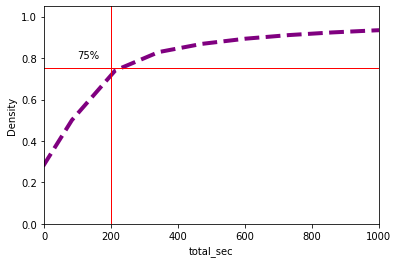

In [23]:
# kdeplot : kernel density estimation 
# density estimation(밀도추정) : (관측된) 데이터들의 분포로부터 원래 변수의 (확률) 분포 특성을 추정하고자 하는 것
# 그러나, 우리가 데이터에 대한 사전 정보를 아는 것은 거의 없기 때문에 사전 정보나 지식 없이 순수하게 관측된 데이터만으로 확률밀도함수를 추정해야 하는데 이를 non-parametric density estimation라 부른다.
# non-parametric density estimation의 대표적인 예가 히스토그램인데 히스토그램은 아래와 같이 3가지의 단점이 있다. 
# 1) bin의 경계에서 불연속성이 나타난다는 점, 
# 2) bin의 크기 및 시작 위치에 따라서 히스토그램이 달라진다는 점, 
# 3) 고차원(high dimension) 데이터에는 메모리 문제 등으로 사용하기 힘들다는 점 등의 문제점을 갖는다.
# 이러한 문제점을 해결하기 위한 그래프가 kdeplot이다. 
# 즉KDE(Kernel Density Estimation)를 통해 얻은 확률밀도함수는 히스토그램 확률밀도함수를 스무딩(smoothing)한 것이 kdeplot이다. 

plt.xlim(0,1000)
plt.text(100, 0.8, '75%')
sns.kdeplot(df1_action['total_sec'], cumulative=True, color = 'purple', linewidth=4, linestyle='--');
plt.axhline(0.75, linewidth = 1, color = 'red');
plt.axvline(200, linewidth = 1, color = 'red');

plt.show()

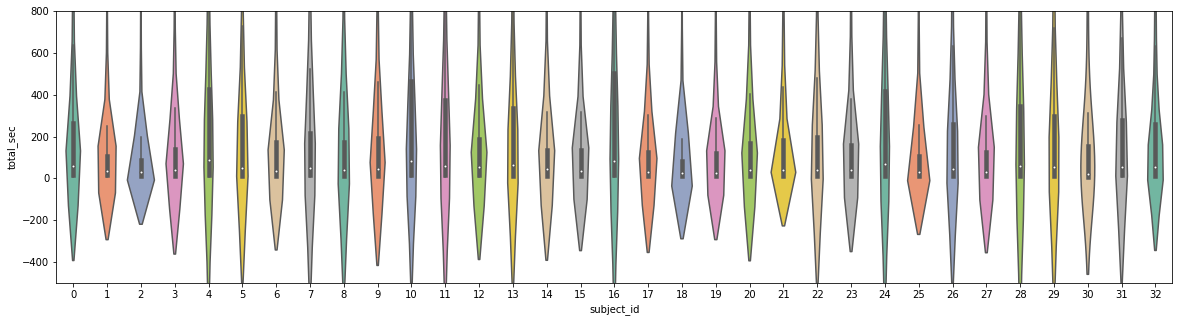

In [24]:
plt.figure(figsize=(20,5))

plt.ylim(-500,800)
sns.violinplot(x = 'subject_id', y='total_sec', data = df1_action.reset_index(), palette="Set2");

plt.show()

In [25]:
# 일부 앱이 크롤링이 잘못되어 직접 수정을 진행하였습니다. 

df1_action["genre"][df1_action.name.str.contains("Melon")] = "Music & Audio"
df1_action["genre_bigcol"][df1_action.name.str.contains("Melon")] = "lifestype"

df1_action["genre"][df1_action.name.str.contains("삼성 인터넷")] = "Productivity"
df1_action["genre_bigcol"][df1_action.name.str.contains("삼성 인터넷")] = "producivity"

df1_action["genre"][df1_action.name.str.contains("Chrome")] = "Productivity"
df1_action["genre_bigcol"][df1_action.name.str.contains("Chrome")] = "producivity"

df1_action["genre"][df1_action.name.str.contains("다음")] = "Productivity"
df1_action["genre_bigcol"][df1_action.name.str.contains("다음")] = "producivity"

df1_action["genre"][df1_action.name.str.contains("검은사막 모바일")] = "Role Playing"
df1_action["genre_bigcol"][df1_action.name.str.contains("검은사막 모바일")] = "game"

df1_action["genre"][df1_action.name.str.contains("YouTube")] = "Video"
df1_action["genre_bigcol"][df1_action.name.str.contains("YouTube")] = "hobby"

In [26]:
top_ap = df1_action.groupby(['genre_bigcol','name'])['total_sec'].agg(['count','mean'])
top_ap['mean'] = top_ap['mean'].map(lambda x: time.strftime('%H:%M:%S', time.gmtime(x)))
top_ap.sort_values('count', ascending=False).head(10).groupby(level=0).head().sort_index(ascending=False)

count      mean
genre_bigcol     name                                 
tools            TouchWiz 홈             4602  00:06:30
                 Samsung Experience 홈  19192  00:05:39
social           트위터                    7222  00:02:42
                 Facebook               4693  00:03:51
self development ABC Platform           9186  00:05:16
producivity      삼성 인터넷                 4859  00:04:53
                 Chrome                 6388  00:03:55
lifestype        캐시워크                   8735  00:10:33
contact          카카오톡                  32328  00:03:24
                 메시지                    4758  00:04:42

In [27]:
top_ap[top_ap['count'] >= 100].sort_values('mean', ascending=False).head(10).groupby(level=0).head().sort_index()

count      mean
genre_bigcol name                                      
game         벽람항로                         473  00:12:23
hobby        AfreecaTV                    184  00:12:40
lifestype    CJ ONE                       258  00:16:47
             Mi 피트                        481  00:12:10
producivity  알람/시간                        126  00:37:01
social       위베어베어스 더퍼즐                   169  00:13:14
tools        AhnLab V3 Mobile Security    204  00:12:30
             기본홈(홈&앱서랍)                   768  00:12:59
             시계                          1687  00:11:09
             알람/시계                        378  00:12:05

In [28]:
from collections import Counter

app_pt = Counter()
genre_pt = Counter()

a_pat = list(zip(set_df1_action['referrer_app'],set_df1_action['name']))
g_pat = list(zip(set_df1_action['referrer_genre'], set_df1_action['genre']))

app_pt.update(a_pat)
genre_pt.update(g_pat)

In [29]:
app_pt.most_common(10)

[(('Samsung Experience 홈', '카카오톡'), 9439),
 (('카카오톡', 'Samsung Experience 홈'), 5756),
 (('모아락', '캐시워크'), 2324),
 (('시스템 UI', '카카오톡'), 2273),
 (('허니스크린', '캐시워크'), 2064),
 (('ABC Platform', '카카오톡'), 2051),
 (('Samsung Experience 홈', 'NAVER'), 1989),
 (('Samsung Experience 홈', 'Instagram'), 1891),
 (('Samsung Experience 홈', '삼성 인터넷'), 1836),
 (('원더락', '캐시워크'), 1694)]

In [30]:
genre_pt.most_common(10)

[(('Tools', 'Communication'), 19923),
 (('Personalization', 'Communication'), 12708),
 (('Communication', 'Tools'), 10653),
 (('Tools', 'Social'), 7416),
 (('Personalization', 'Social'), 6709),
 (('Tools', 'Tools'), 6635),
 (('Communication', 'Communication'), 5594),
 (('Health & Fitness', 'Communication'), 4868),
 (('Lifestyle', 'Health & Fitness'), 4354),
 (('Communication', 'Personalization'), 4040)]

In [31]:
genre_pt_1000 = genre_pt.most_common(100)

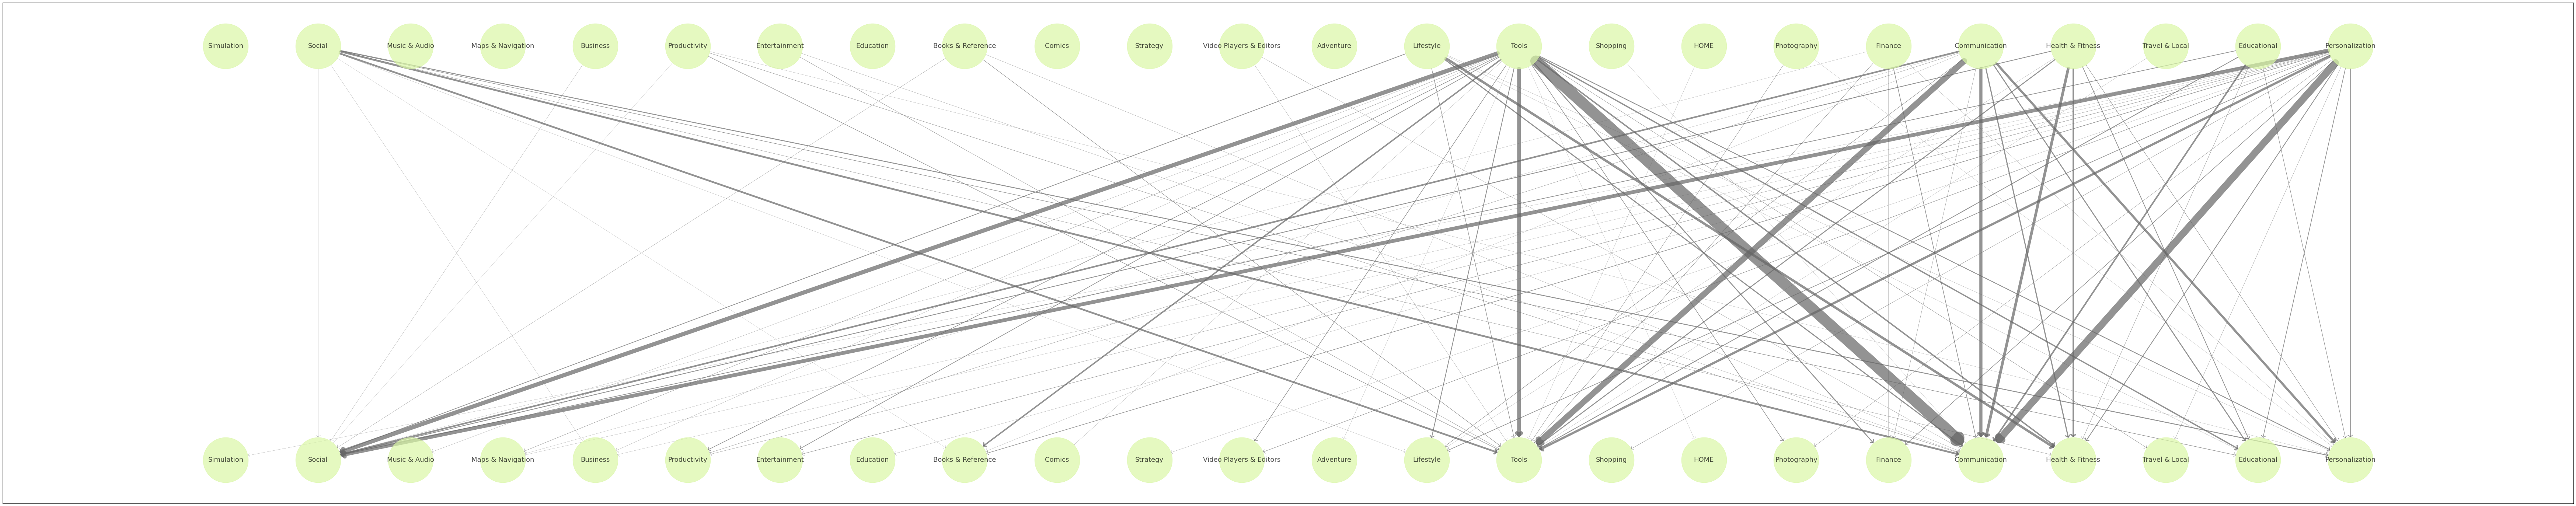

In [32]:
import networkx as nx
import numpy as np

plt.figure(figsize=(125,25))

G1_keys = set([k[0] for k, _ in genre_pt_1000 if all(k) is True])
G2_keys = set([k[1] for k, _ in genre_pt_1000 if all(k) is True])
G_keys = G1_keys.union(G2_keys)
num_keys = len(G_keys)
G_mapping = {k: v for v, k in enumerate(G_keys)}
G_rev_mapping = {k: v for k, v in enumerate(G_keys)}

edge_list = []
for edge, weight in genre_pt_1000:
    if all(edge) is False: continue
    mapped_edge = (G_mapping[edge[0]], G_mapping[edge[1]] + num_keys, weight)
    edge_list.append(mapped_edge)

node_labels = {k: v for k, v in G_rev_mapping.items()}
node_labels.update({k + num_keys: v for k, v in G_rev_mapping.items()})

DG = nx.DiGraph()

DG.add_weighted_edges_from(edge_list)
DG.add_nodes_from([k for k in G_rev_mapping.keys()])

pos = {}
for node in node_labels.keys():
    x_spacing = np.linspace(-0.8, 0.8, num_keys)
    x = x_spacing[node] if node < num_keys else x_spacing[node - num_keys]
    y = 0.5 if node < num_keys else -0.5
    pos[node] = (x, y)

edge_width = [DG[u][v]['weight'] for u, v in DG.edges()]
normalized_edge_width = [30 * width / max(edge_width) for width in edge_width]

# plt.figure(1, figsize=(24, 8))
graph = nx.draw_networkx(DG, pos,
                         alpha=0.7,
                         with_labels=True, width=normalized_edge_width,
                         edge_color='.4', node_color = '#DAF7A6', node_size=15000, labels=node_labels, font_size = 18,
                         arrowstyle='->,head_width=0.6,head_length=0.5')

In [33]:
app_pt_100 = app_pt.most_common(100)

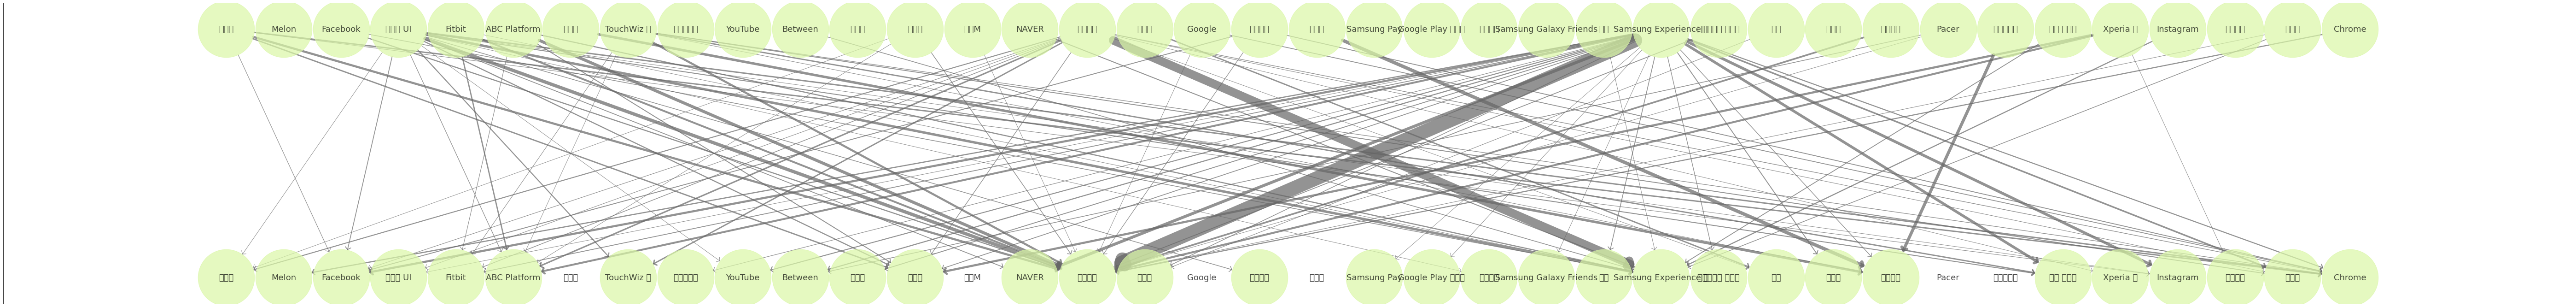

In [34]:

plt.figure(figsize=(100,12))

G1_keys = set([k[0] for k, _ in app_pt_100 if all(k) is True])
G2_keys = set([k[1] for k, _ in app_pt_100 if all(k) is True])
G_keys = G1_keys.union(G2_keys)
num_keys = len(G_keys)
G_mapping = {k: v for v, k in enumerate(G_keys)}
G_rev_mapping = {k: v for k, v in enumerate(G_keys)}

edge_list = []
for edge, weight in app_pt_100:
    if all(edge) is False: continue
    mapped_edge = (G_mapping[edge[0]], G_mapping[edge[1]] + num_keys, weight)
    edge_list.append(mapped_edge)

node_labels = {k: v for k, v in G_rev_mapping.items()}
node_labels.update({k + num_keys: v for k, v in G_rev_mapping.items()})

DG = nx.DiGraph()

DG.add_weighted_edges_from(edge_list)
DG.add_nodes_from([k for k in G_rev_mapping.keys()])

pos = {}
for node in node_labels.keys():
    x_spacing = np.linspace(-0.8, 0.8, num_keys)
    x = x_spacing[node] if node < num_keys else x_spacing[node - num_keys]
    y = 0.5 if node < num_keys else -0.5
    pos[node] = (x, y)

edge_width = [DG[u][v]['weight'] for u, v in DG.edges()]
normalized_edge_width = [30 * width / max(edge_width) for width in edge_width]

plt.figure(1, figsize=(24, 8))
graph = nx.draw_networkx(DG, pos,
                         alpha=0.7,
                         with_labels=True, width=normalized_edge_width,
                         edge_color='.4', node_color = '#DAF7A6', node_size=15000, labels=node_labels, font_size = 18,
                         arrowstyle='->,head_width=0.6,head_length=0.5')

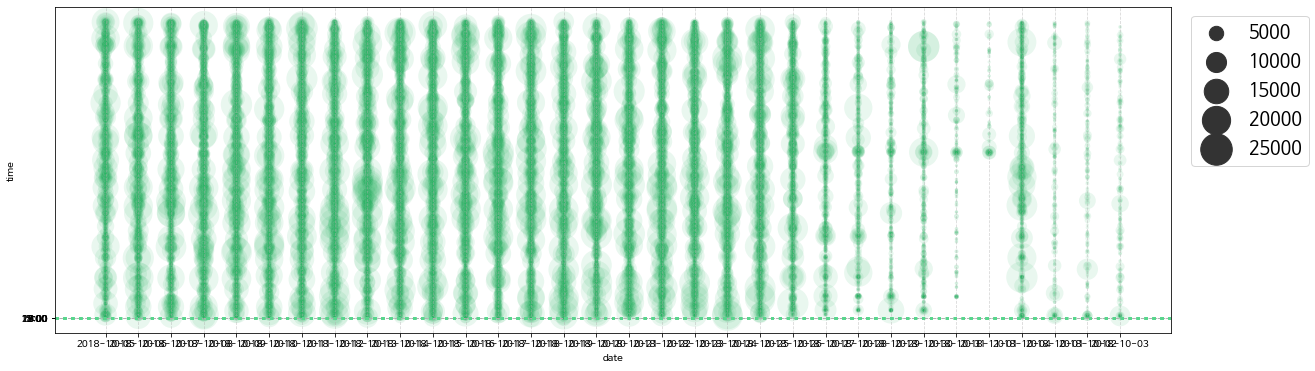

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.rc('font', family='NanumBarunGothic') 
fig, ax = plt.subplots(figsize = (20,6))

pd.plotting.register_matplotlib_converters()

dt = df1_action.reset_index()[['date','time','total_sec','subject_id']]
# dt = dt.sort_values(by="date", ascending=True)
# dt["time"] = pd.to_datetime(dt["time"])

x = dt.date
y = dt.time
size = dt.total_sec
ytick = [f'{x}:00' for x in range(3,24,3)]
timepoints = ['00:01','06:00','12:00','18:00','23:59']

sns.scatterplot(x = x, y = y, size = size, sizes = (10,1000), alpha = 0.1, color = '#28B463')
plt.grid(True, alpha = 0.5, linestyle = '--')

# plt.xticks(fontsize = 15)
plt.yticks(ytick)

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, prop={'size': 18})
for tp in timepoints: plt.axhline(tp, color = '#58D68D', linewidth = 3, linestyle = ':')
plt.show();

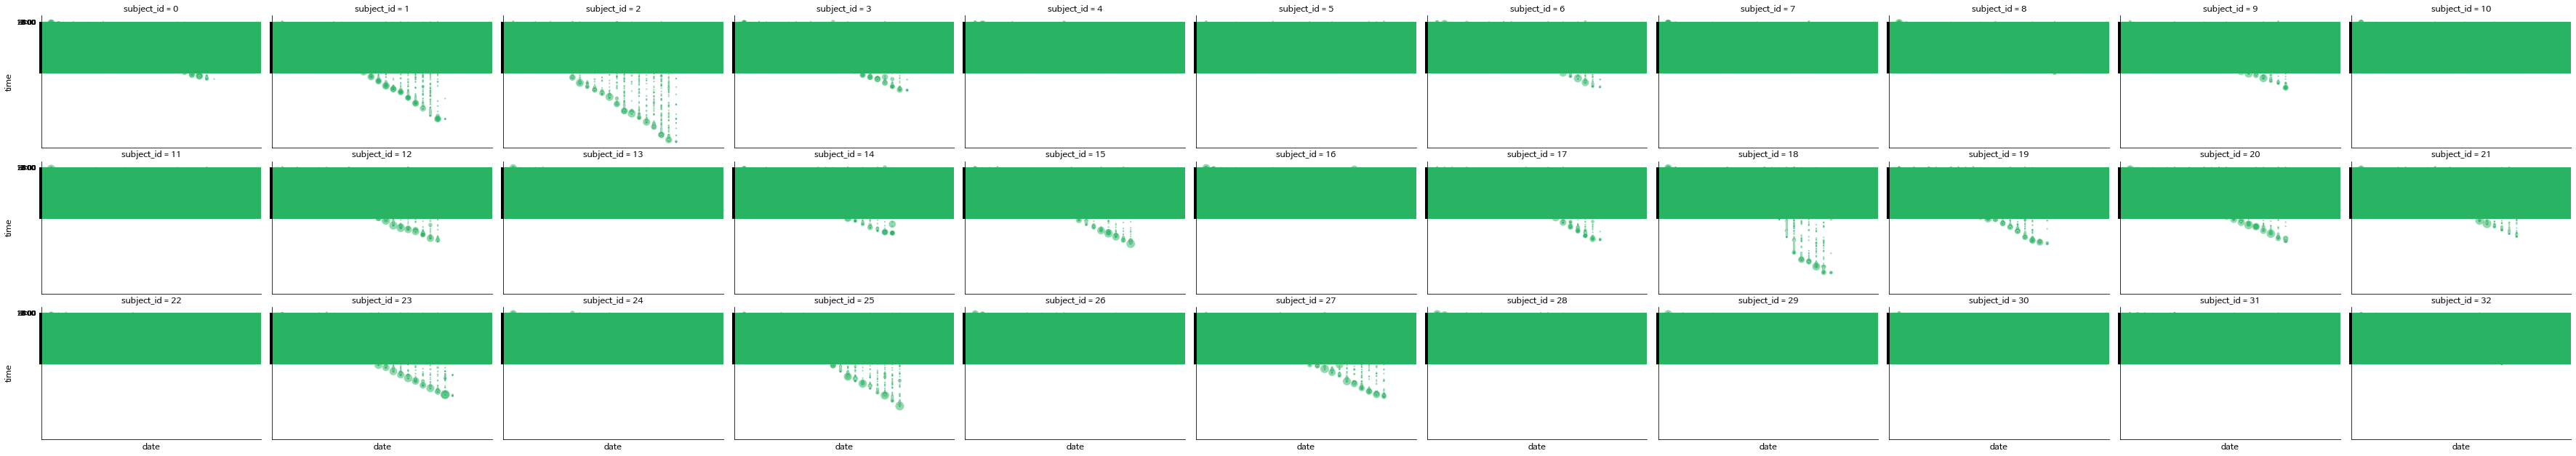

In [36]:
pd.plotting.register_matplotlib_converters()


dt = df1_action.reset_index()[['date','time','total_sec','subject_id']]

g = sns.FacetGrid(dt, col = 'subject_id', col_wrap = 11, aspect = 1.5)
g.map(sns.scatterplot, "date", "time", size = size, sizes = (5,150), color = '#28B463', alpha = 0.5)
ytick = [f'{x}:00' if x!= 24 else '23:00' for x in range(-6,25,6)]

plt.grid(True)
plt.xticks([])
g.fig.subplots_adjust(wspace=.05, hspace=.1)

for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize='large')
    ax.set_xlabel(ax.get_xlabel(), fontsize='large')
    ax.set_ylabel(ax.get_ylabel(), fontsize='large')
    ax.set_yticklabels(ytick, fontsize='medium')
    ax.grid(color='#28B463', linestyle=':', linewidth= 0.5)

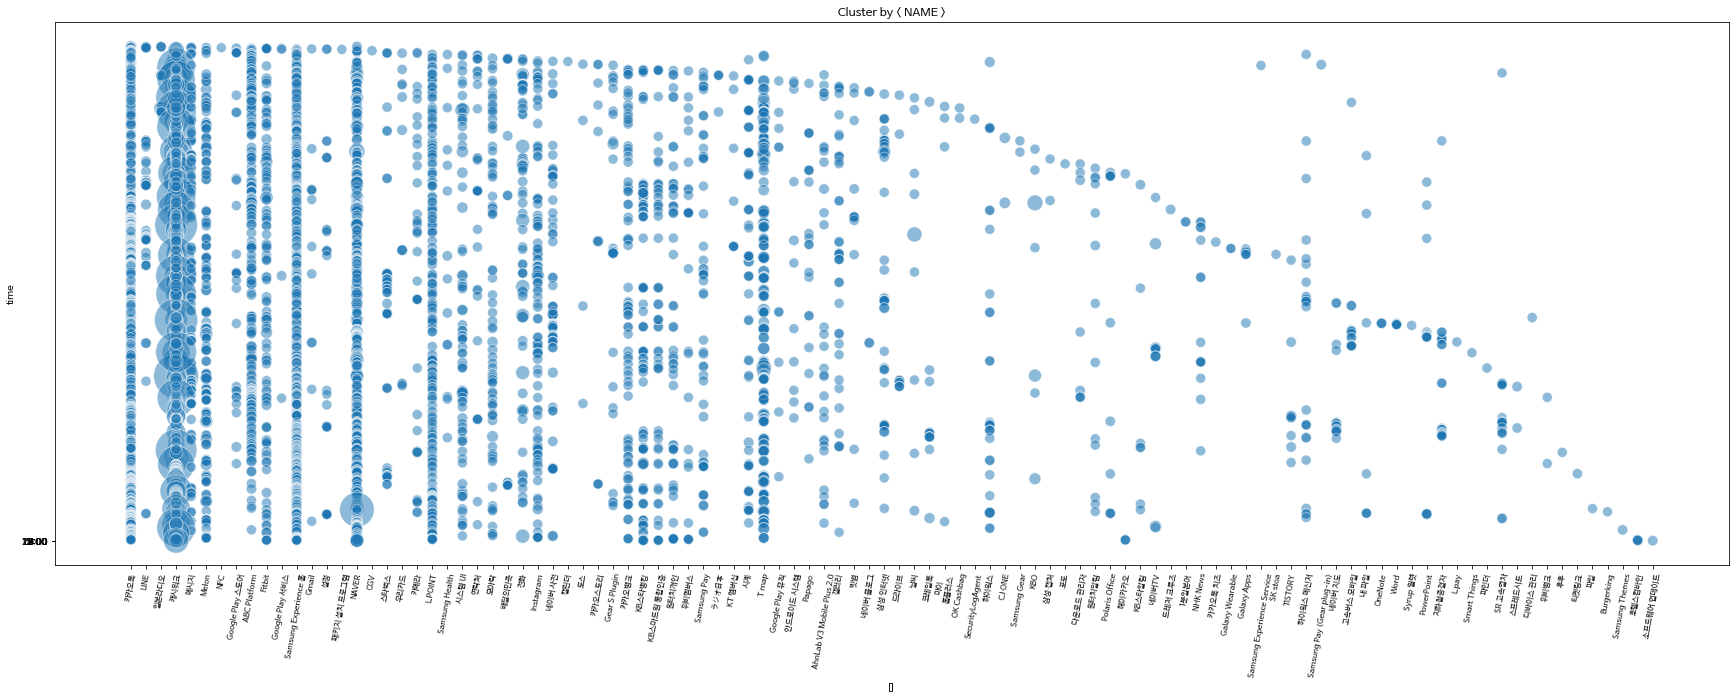

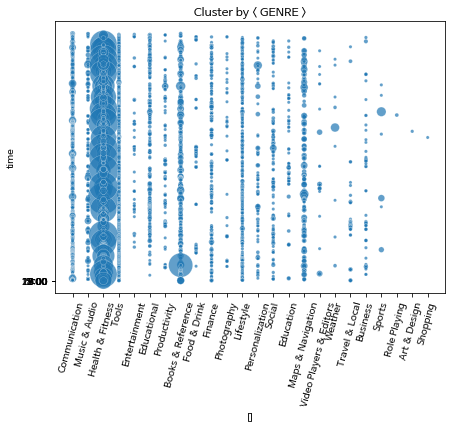

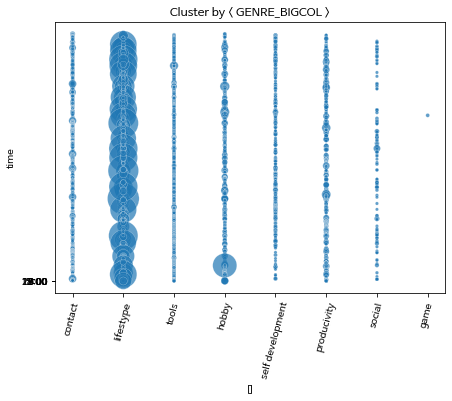

In [37]:
from matplotlib import rc
rc('font', family='NanumBarunGothic') 

pd.plotting.register_matplotlib_converters()

palette = sns.color_palette("Set2",4)
ytick = [f'{x}:00' for x in range(3,24,3)]

df = df1_action.loc[27]

for v in ['name','genre','genre_bigcol']:
    if v == 'name':
        plt.figure(figsize=(30,10));
        plt.xticks(rotation=80, fontsize=8);
        sns.scatterplot(x= v, y = 'time', size = 'total_sec', alpha = 0.5, sizes = (100,2000),
                        data=df, palette= palette, legend = False);
    else:
        plt.figure(figsize=(7,5));
        sns.scatterplot(x= v, y = 'time', size = 'total_sec', alpha = 0.7, sizes = (10,1000),
                        data=df, palette= palette, legend = False);
        plt.xticks(rotation=75)
        
    plt.yticks(ytick)
    plt.title(f'Cluster by < {v.upper()} >')
    plt.xlabel([])
    plt.show();

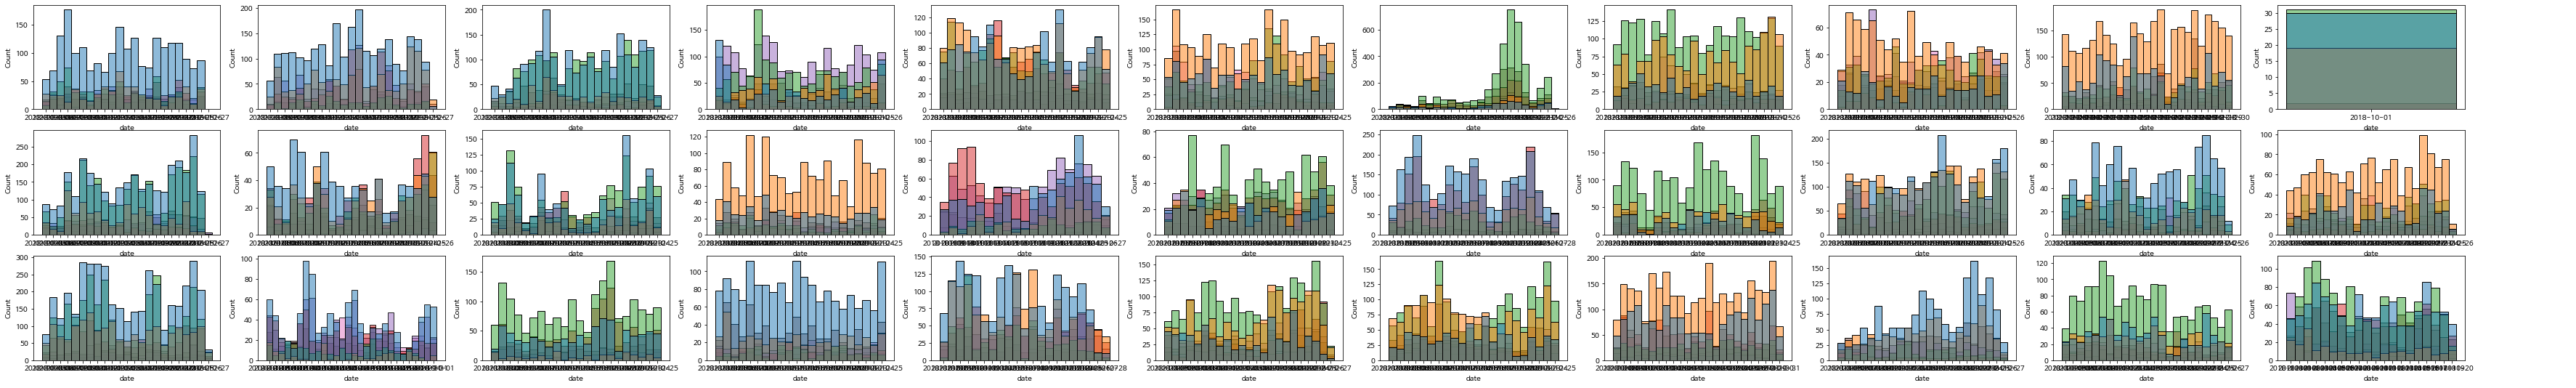

In [38]:
fig = plt.figure(figsize=(60,9))
axes = fig.subplots(nrows=3, ncols=11)

handles = []
labels = df1_action.genre_bigcol.unique()

for i in range(33):
    col = i // 3
    row = i % 3
    
    df = df1_action.loc[i]
    g = sns.histplot(df, x='date', hue='genre_bigcol', ax= axes[row, col], legend = False);
    handles.append(g)

fig.legend(labels, loc="upper right", bbox_to_anchor=[0.935, 0.88], shadow=True, fancybox=True)

plt.show()

In [39]:
my_freq = df1_action.groupby(['subject_id'])['name'].value_counts(normalize=True)
all_freq = df1_action['name'].value_counts(normalize=True)

def cal_importance(row):
    
    pid = row['subject_id']
    app_name = row['name']
    stay_time = row['total_sec']
    my_impt, all_impt = my_freq.loc[pid][app_name], all_freq[app_name]
    importance = round(my_impt / all_impt, 2)
    importance = importance*(stay_time/60) 
    return importance

In [40]:
df1_action['importance'] = list(df1_action.reset_index().apply(cal_importance, axis=1))

In [41]:
df1_action.importance.max()

20844.085166666668

In [42]:
def importance_detector(rows):
    time = rows.total_sec
    importance = rows.importance
    
    if (time >= 300) & (importance > 3): return 4
    elif time >= 300: return 3
    elif importance > 3: return 2
    else: return 1

In [43]:
df1_action['importance_cat'] = list(df1_action.apply(importance_detector, axis=1))

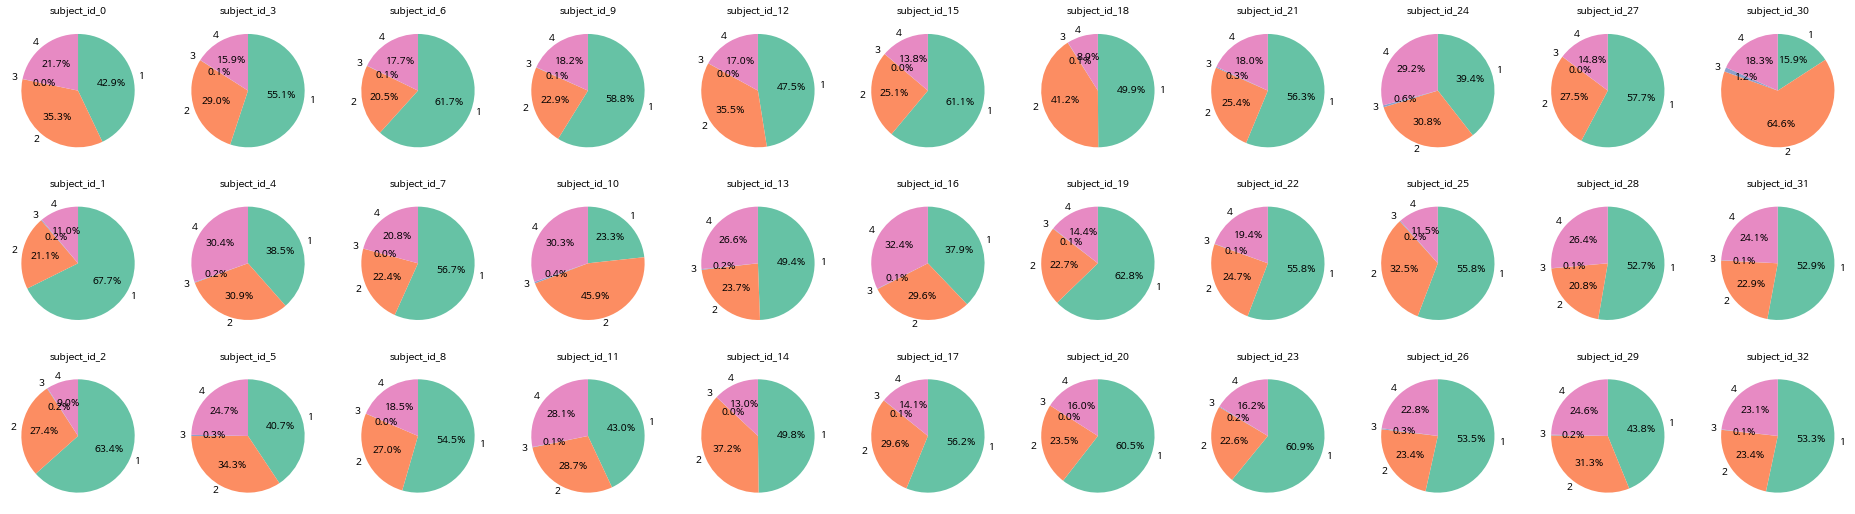

In [44]:
pie_df = pd.DataFrame(df1_action.groupby('subject_id')['importance_cat'].value_counts(normalize=True)).sort_index(level=(0,1)).rename(columns = {'importance_cat':'ratio'})


fig = plt.figure(figsize=(33,9))
axes = fig.subplots(nrows=3, ncols=11)

handles = []
labels = df1_action.genre.unique()
pal = sns.color_palette("Set2", 4)

for i in range(33):
    col = i // 3
    row = i % 3
    
    df = pie_df.loc[i]
    axes[row,col].pie(df['ratio'], labels= df.index, startangle=90, counterclock=False, colors = pal,  autopct='%1.1f%%', textprops={'fontsize':10});
    axes[row,col].set_title(f'subject_id_{i}', fontsize=10)
    

plt.show()

In [45]:
df1_action.groupby('importance_cat')['total_sec'].agg(['mean','count'])

mean   count
importance_cat                     
1                 27.736006  101794
2                109.861822   52693
3                467.018868     265
4               1441.827150   32855

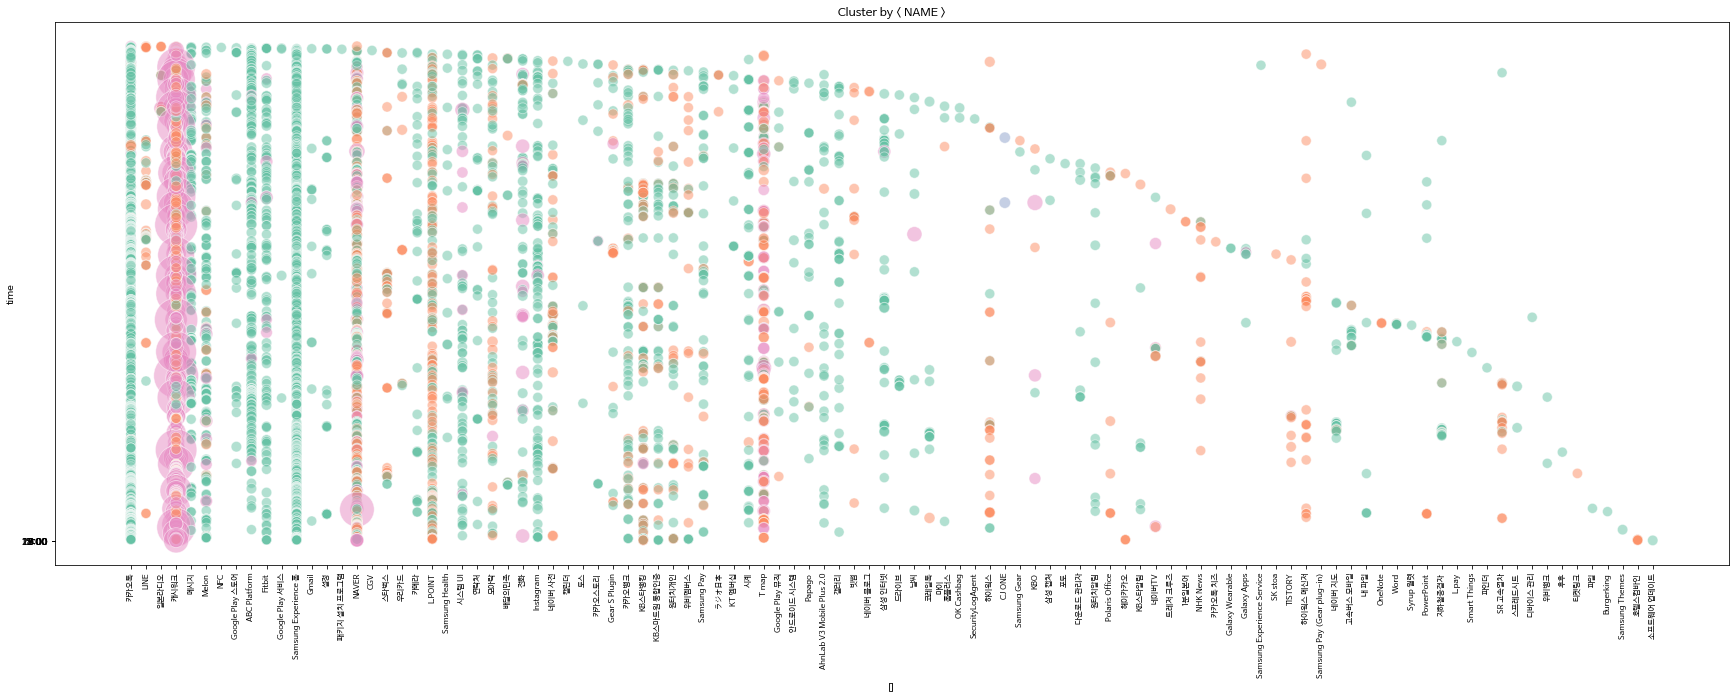

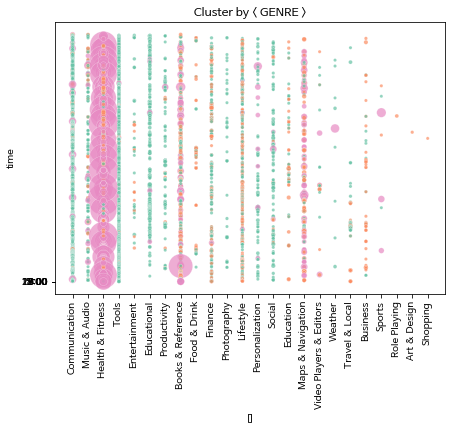

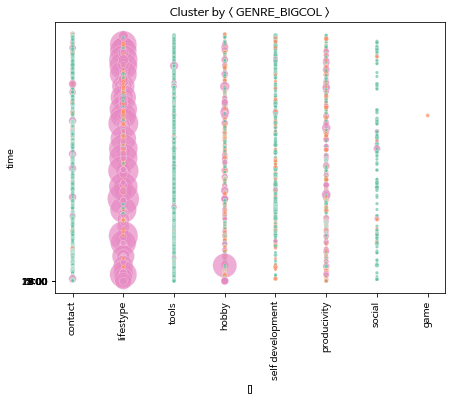

In [46]:
from matplotlib import rc
rc('font', family='NanumBarunGothic') 

pd.plotting.register_matplotlib_converters()

palette = sns.color_palette("Set2",4)
ytick = [f'{x}:00' for x in range(3,24,3)]

df = df1_action.loc[27]

for v in ['name','genre','genre_bigcol']:
    if v == 'name':
        plt.figure(figsize=(30,10));
        plt.xticks(rotation=90, fontsize=8);
        sns.scatterplot(x= v, y = 'time', size = 'total_sec', hue='importance_cat', alpha = 0.5, sizes = (100,2000),
                        data=df, palette= palette, legend = False);
    else:
        plt.figure(figsize=(7,5));
        sns.scatterplot(x= v, y = 'time', size = 'total_sec', hue='importance_cat', alpha = 0.7, sizes = (10,1000),
                        data=df, palette= palette, legend = False);
        plt.xticks(rotation=90)
        
    plt.yticks(ytick)
    plt.title(f'Cluster by < {v.upper()} >')
    plt.xlabel([])
    plt.show();

In [47]:
train = df1_action.reset_index()[['subject_id','name','is_system_app','genre','genre_bigcol', 'time','referrer_package','referrer_app','referrer_genre','total_sec','importance_cat']]
train.dropna(inplace = True)



In [48]:
#시계열 data, 이후의 데이터를 예측

val_len = int(len(train)*0.1)
target = ['genre_bigcol'] #다음으로 올 genre는?

y_train = train[target]
x_train = train.drop(target, axis = 1)

x_val = x_train.iloc[(val_len)*-2:]
y_val = y_train.iloc[(val_len)*-2:]

x_train = x_train.drop(x_val.index)
y_train = y_train.drop(y_val.index)

In [49]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((150087, 10), (150087, 1), (37520, 10), (37520, 1))

In [13]:
!pip install category_encoders

     |████████████████████████████████| 81kB 6.2MB/s 


In [14]:
import category_encoders
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier

In [52]:
pipe = make_pipeline(
    OrdinalEncoder(),
    MultiOutputClassifier(LGBMClassifier(
                                        objective = 'multiclass',
                                        metric = 'multi_logloss'
                                        ))
)

In [53]:
pipe.fit(x_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['name', 'genre', 'time',
                                      'referrer_package', 'referrer_app',
                                      'referrer_genre'],
                                mapping=[{'col': 'name',
                                          'data_type': dtype('O'),
                                          'mapping': Samsung Experience 홈        1
쏠캘린더                        2
Samsung Galaxy Friends      3
삼성 인터넷                      4
리마인더                        5
                         ... 
LFmall                    635
할리스커피                     636
굿모닝 스페인어 사전               637
비디오 에디터 Lite              638
NaN                        -2
Length: 639, dtype: int64},
                                         {'col': 'genre',
                                          'data_type': dtype('O...
Business                   23
Casual                     24
Arcade                     25
Music & Audio        

In [54]:
y_pred = pipe.predict(x_val)

In [55]:
## 전체 predict
print(classification_report(y_val, y_pred))

                  precision    recall  f1-score   support

         contact       1.00      1.00      1.00      8440
            game       1.00      0.63      0.77       140
           hobby       0.96      1.00      0.98      3014
       lifestype       1.00      1.00      1.00      5423
     producivity       0.99      0.97      0.98      4418
self development       1.00      1.00      1.00      2160
          social       1.00      1.00      1.00      4517
           tools       1.00      1.00      1.00      9408

        accuracy                           0.99     37520
       macro avg       0.99      0.95      0.97     37520
    weighted avg       1.00      0.99      0.99     37520



#### XGBRegressor
각 사용자별 선호 + 어플리케이션 사용 패턴을 바탕으로 사용자의 특정 어플리케이션 이용 시간을 예측해봄
- Train:
    - 전체 데이터셋의 80%, 약 119432개의 data
    - Feature: 'pid','name','is_system_app','time','genre','genre_bigcol','referrer_package','referrer_app','referrer_genre','importance_cat'
    - Target: 'total_sec'
  
- Validation:
    - 시계열 데이터로 이전 데이터들을 train시켜 이후의 데이터를 예측하도록 했기에 cross validation이 불가,
    - 전체의 0.2만큼을 떼어내어 hold out validation으로 진행
    
- Result:
    - Weighted Average 0.27
    - p_id별로 나누어 따로따로 모델을 돌리면 정확도가 0.40 정도까지 올라가는 것으로 보아 모델 자체에서 pid를 구분해 개인의 취향과 패턴을 제대로 익히지는 못하는 것으로 보임.

In [56]:
train = df1_action.reset_index()[['subject_id','name','is_system_app','time','genre','genre_bigcol','referrer_package','referrer_app','referrer_genre','importance_cat', 'total_sec']]
train.dropna(inplace = True)

In [57]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

pipe = make_pipeline(
    OrdinalEncoder(),
    LGBMRegressor(
    )   
)

In [58]:
val_len = int(len(train)*0.1)
target = 'total_sec' #다음으로 올 genre는?

y_train = train[target]
X_train = train.drop(target, axis = 1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# xgboost ValueError: feature_names mismatch 해결하기 위한 코드 
X_train = np.asmatrix(X_train)
X_val = np.asmatrix(X_val)

In [59]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((150085, 10), (150085,), (37522, 10), (37522,))

In [60]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                mapping=[{'col': 0, 'data_type': dtype('O'),
                                          'mapping': 4.0      1
1.0      2
27.0     3
25.0     4
17.0     5
29.0     6
22.0     7
28.0     8
18.0     9
8.0     10
15.0    11
2.0     12
0.0     13
23.0    14
21.0    15
26.0    16
19.0    17
32.0    18
6.0     19
3.0     20
12.0    21
11.0    22
10.0    23
14.0    24
9.0     25
31.0    26
7.0     27
20.0    28
5.0     29
24.0    30
16.0    31
13.0    32
30.0    33
NaN     -2
dtype: int64},
                                         {'col': 1, 'data_type': dtype...
Maps & Navigation          23
Shopping                   24
Weather                    25
Role Playing               26
Food & Drink               27
Strategy                   28
Libraries & Demo           29
House & Home               30
Racing                     31
Puzzle                     32
Com

In [61]:
y_pred = pipe.predict(X_val)

In [63]:
!pip install scikit-learn==0.24

In [64]:
from sklearn.model_selection import cross_val_score
import sklearn.metrics

k = 3 # 3-fold 교차검증을 수행
scores = cross_val_score(pipe, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_percentage_error') #evaluation metrics 설정

## 본래 사용 시간이 300분인 것을 310분으로 예상하는 것과, 1초만에 끝날 것을 1분이라 예상하는 것은 엄연히 다르다.
## 이에 크기 기반이 아닌, 비율을 기반으로 한 예측이 필요 -> neg_mean_absolute_percentage_error로 선정


In [66]:
-scores

array([1.60383308, 1.68276717, 2.19150506])

In [67]:
from sklearn.model_selection import cross_val_score

k = 3 # 3-fold 교차검증을 수행
scores = cross_val_score(pipe, X_val, y_val, cv=k, 
                         scoring='neg_mean_absolute_percentage_error') #evaluation metrics 설정

## 본래 사용 시간이 300분인 것을 310분으로 예상하는 것과, 1초만에 끝날 것을 1분이라 예상하는 것은 엄연히 다르다.
## 이에 크기 기반이 아닌, 비율을 기반으로 한 예측이 필요 -> neg_mean_absolute_percentage_error로 선정


In [68]:
-scores #오차범위 6~7.5% 사이를 기록하며 꽤 좋은 성능을 보임

array([1.83180525, 1.79908616, 1.78010683])

In [69]:
from sklearn.model_selection import cross_validate
cv_result = cross_validate(pipe, X_train, y_train, cv=k,
                            scoring='neg_mean_absolute_percentage_error',
                            return_estimator=True) #evaluation metrics 설정

In [70]:
-cv_result['test_score']

array([1.60383308, 1.68276717, 2.19150506])

In [71]:
reg_fit = cv_result['estimator']
len(reg_fit) #3cross validation이니까 3개여야함

3

In [72]:
%store reg_fit

Stored 'reg_fit' (list)


# Deep Learning

- 목적: 각 소비자별 선호 + 어플리케이션 사용 패턴을 바탕으로 각 소비자가 다음에 사용할 ‘어플리케이션 명’를 예측하는 것.<br/>(딥러닝 모델의 경우 대장르 예측은 물론이고, 전반적으로 압도적으로 뛰어난 성능을 보였기 때문에 보다 어려운 태스크를 요구해 봄)

- Baseline Model Accuracy: 1 / 693 *100 = 0.001 (어플리케이션은 모두 693개)

- TRAIN:    
    - Feature: 개인ID, 사용 어플리케이션명, 어플리케이션 장르, 행위 그룹(1,2,3,4), 시간, 사용 시간대, Referrer(현재 어플리케이션으로 이동하기 전에 사용한) 어플리케이션명,  Referrer 장르, Referrer 패키지
    - Target: 사용 어플리케이션명

- MODEL: 훈련 데이터를 벡터화, 이를 임베딩 층에 가중치로 주입하고, LSTM 사용.

- TEST:
- 미래 사용할 어플리케이션을 예측할 때에는 어플리케이션을 알 지 못하므로 그 행위가 어떤 그룹에 속할지를 알 수는 없음.
- 이에, 관심도를 주지 않은 상태로 예측을 시켜 봄. (딥러닝 신경망 모델에서는 인풋 Shape가 모델이 구성된 Shape와 정확히 일치하지 않아도 예측이 가능했었음)

- Result:
    - weighted average 0.75
    - 갯수가 적은 클래스에 대해서는 예측력이 떨어지나, 충분한 기록이 있는 클래스에 대해서는 좋은 성능을 보임
    - 테스트 셋에서 각 행위가 해당하는 중요도 그룹을 말해주지 않더라도, 이미 모델은 훈련과정에서 개인들의 취향, 패턴을 파악했기에 다음과 같은 좋은 accuracy를 낼 수 있었던 것으로 보임

In [32]:
import tensorflow as tf

In [33]:
data = df1_action.reset_index()[["subject_id",	"name",	"is_system_app",	"type",	"genre",	"referrer_package",	"referrer_app",	"referrer_genre",	"total_sec"]]

In [34]:
data.head(2)

subject_id                  name  is_system_app                type  \
0           0  Samsung Experience 홈              1  MOVE_TO_FOREGROUND   
1           0                  쏠캘린더              0  MOVE_TO_FOREGROUND   

     genre               referrer_package            referrer_app  \
0    Tools  com.samsung.android.mateagent  Samsung Galaxy Friends   
1  Finance   com.sec.android.app.launcher    Samsung Experience 홈   

  referrer_genre  total_sec  
0          Tools        5.0  
1          Tools        9.0

In [35]:
data.shape

(187607, 9)

In [36]:
encoder = OrdinalEncoder()
encoded_data = encoder.fit_transform(data)
encoded_data.dtypes

subject_id            int64
name                  int64
is_system_app         int64
type                  int64
genre                 int64
referrer_package      int64
referrer_app          int64
referrer_genre        int64
total_sec           float64
dtype: object

In [37]:
encoded_data.head(2)

subject_id  name  is_system_app  type  genre  referrer_package  \
0           0     1              1     1      1                 1   
1           0     2              0     1      2                 2   

   referrer_app  referrer_genre  total_sec  
0             1               1        5.0  
1             2               1        9.0

In [38]:
target = ['name']

In [41]:
X_train = encoded_data.drop(target, axis=1).to_numpy()
y_train = encoded_data[target]
X_train.shape, y_train.shape

((187607, 8), (187607, 1))

In [42]:
from tensorflow.keras.utils import to_categorical
y_train = y_train - 1 #to_categorical은 0부터 시작인데 우리의 타겟은 1부터 인코딩됨 -> 1 빼주기

y_train = to_categorical(y_train)
print(y_train)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [47]:
from sklearn.model_selection import train_test_split
X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2)

In [48]:
X_train.shape, x_val.shape, y_train.shape, y_val.shape

((150085, 8), (37522, 8), (150085, 738), (37522, 738))

In [53]:
tf.random.set_seed(1023)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(X_train), 238, input_length = 10),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.LSTM(256, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(738, activation='softmax')
              ]) 


checkpoint_filepath = "FMbest.hdf5"

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3, verbose=1)

save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, monitor='val_accuracy', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None)


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train,
          batch_size= 32,
          validation_split= 0.2,
          callbacks= [early_stop, save_best],
          epochs= 2)

model.summary()

Epoch 1/2
3753/3753 [==============================] - 752s 200ms/step - loss: 1.5845 - accuracy: 0.6393 - val_loss: 0.8866 - val_accuracy: 0.7756

Epoch 00001: val_accuracy improved from -inf to 0.77556, saving model to FMbest.hdf5
Epoch 2/2
3753/3753 [==============================] - 726s 193ms/step - loss: 0.7352 - accuracy: 0.7963 - val_loss: 0.6613 - val_accuracy: 0.8136

Epoch 00002: val_accuracy improved from 0.77556 to 0.81361, saving model to FMbest.hdf5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 10, 238)           35720230  
_________________________________________________________________
dense_4 (Dense)              (None, 10, 256)           61184     
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_______________________________________________

In [55]:
x_val = np.delete(x_val,-1,1) #importance_cat(마지막 value)를 지워줌
x_val

array([[  6.,   0.,   2., ...,  62.,  62.,  19.],
       [ 22.,   0.,   1., ...,   5.,   5.,   4.],
       [ 15.,   0.,   1., ..., 422., 413.,   4.],
       ...,
       [ 25.,   0.,   1., ..., 650., 631.,   7.],
       [ 17.,   0.,   1., ...,   2., 272.,   4.],
       [ 32.,   0.,   1., ...,   2.,   2.,   1.]])

In [56]:
y_pred = model.predict(x_val)

In [257]:
# 데이터 및 테스트셋 구분
X_train = encoded_data.sample(frac=0.8,random_state=0)
X_val = encoded_data.drop(X_train.index)

In [57]:
y_pred.shape

(37522, 738)

In [58]:
import numpy as np
predicted_categories = np.argmax(y_pred, axis = 1)
predicted_categories[:2]

array([5, 5])

In [59]:
true_categories = tf.concat([[y for y in y_val]], axis = 0).numpy()
true_categories[:2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [60]:
true_categories_argmax = np.argmax(true_categories, axis = 1)
true_categories_argmax[:2]

array([5, 5])

In [61]:
print(classification_report(true_categories_argmax, predicted_categories))

              precision    recall  f1-score   support

           0       0.88      0.98      0.92      3895
           1       0.38      0.18      0.24        17
           2       0.47      0.68      0.55       280
           3       0.66      0.56      0.60       955
           4       0.00      0.00      0.00         5
           5       0.87      0.99      0.93      6337
           6       0.32      0.39      0.35       340
           7       0.45      0.81      0.58        67
           8       0.95      0.76      0.84       205
           9       0.81      0.89      0.85       860
          10       0.00      0.00      0.00        40
          11       0.63      0.91      0.74       201
          12       1.00      1.00      1.00      1830
          13       0.55      1.00      0.71        21
          14       0.40      0.33      0.36        12
          15       0.00      0.00      0.00        67
          16       0.96      1.00      0.98       104
          17       0.93    

In [ ]:
df1_action["name"][df1_action.name.str.contains("토스")]

In [65]:
# 토스를 사용는 프로젝트 참여자 ( 18/33 )
# 해당 참여자들만 가지고 분석을 진행해보겠습니다. 
len([3, 6, 7, 8, 9,11,12,15,17,18,20,22,23,24,26,27,31,32])

18